In [1]:
# Step 1: Install Pathway, Bokeh, Panel, and ensure Pathway is updated
!pip install pathway>=0.10.0 bokeh panel --quiet --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn
# Installs and sets up all the tools needed for the project.

In [2]:
# This code loads main parking data, organizes its time information, and sorts it correctly.
import pandas as pd

file_path = 'dataset.csv'
df = pd.read_csv(file_path)

if 'Timestamp' not in df.columns:
    if 'LastUpdatedDate' in df.columns and 'LastUpdatedTime' in df.columns:
        df['Timestamp'] = df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime']
    else:
        pass

df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce').fillna(0).astype(int)
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce').fillna(0).astype(int)
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce').fillna(0).astype(int)
df['TrafficConditionNearby'] = pd.to_numeric(df['TrafficConditionNearby'], errors='coerce').fillna(0).astype(int)
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce').fillna(0).astype(int)

df['t_pandas'] = pd.to_datetime(df['Timestamp'], format="%d-%m-%Y %H:%M:%S")
df['hour'] = df['t_pandas'].dt.hour
df['day_of_week'] = df['t_pandas'].dt.dayofweek # Monday=0, Sunday=6.

In [3]:
import pathway as pw
print(f"Pathway version: {pw.__version__}")

Pathway version: 0.24.1


In [4]:
# This code prepares your data and sets up Pathway to simulate a real-time data stream with corrected column types and datetime format.
import pathway as pw
import panel as pn
import bokeh.plotting

# Ensure the CSV includes the new 'hour' and 'day_of_week' columns
df.to_csv("parking_data_stream.csv", index=False)

class ParkingSchema(pw.Schema):
    ID: str
    SystemCodeNumber: str
    Capacity: int
    Latitude: float
    Longitude: float
    Occupancy: int
    VehicleType: str
    TrafficConditionNearby: int
    QueueLength: int
    IsSpecialDay: int
    LastUpdatedDate: str
    LastUpdatedTime: str
    Timestamp: str
    hour: int       # NEW: Added hour to schema
    day_of_week: int # NEW: Added day_of_week to schema

data = pw.demo.replay_csv("parking_data_stream.csv", schema=ParkingSchema, input_rate=1000)

# The 'fmt' variable for Pathway's strptime, now correctly formatted
fmt = "%d-%m-%Y %H:%M:%S"
data_with_t = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt)
)
data_with_time = data_with_t.with_columns(
    day = data_with_t.t.dt.strftime("%Y-%m-%dT00:00:00")
)

# Define constants for pricing models
BASE_PRICE = 10
ALPHA = 5
Q_WEIGHT = 0.5
T_WEIGHT = 0.3
S_WEIGHT = 2.0
BETA_DEMAND = 0.5

In [5]:
# This code creates first, simple dynamic pricing model based on current occupancy rate.
current_occupancy_rate = data_with_time.Occupancy / data_with_time.Capacity
price_model1 = BASE_PRICE + ALPHA * current_occupancy_rate

data_with_price_model1 = data_with_time.with_columns(
    price_model1=price_model1
)

In [6]:
# MODEL 1
import panel as pn
import bokeh.plotting
import pandas as pd

# This cell calculates price_model1 and visualizes it using Pandas.

pn.extension()

# --- Calculation of price_model1 (ensuring it's available for plotting) ---
# Ensure BASE_PRICE and ALPHA (from earlier steps) are defined in your notebook.
df['current_occupancy_rate'] = df.apply(
    lambda row: row['Occupancy'] / row['Capacity'] if row['Capacity'] != 0 else 0.0,
    axis=1
)
df['price_model1'] = BASE_PRICE + ALPHA * df['current_occupancy_rate']
# --- End of price_model1 calculation ---

df_sorted_for_viz = df.sort_values(by='t_pandas')

source_model1 = bokeh.models.ColumnDataSource(df_sorted_for_viz)

viz_model1 = bokeh.plotting.figure(
    height=300, width=800,
    title="Model 1: Parking Prices Over Time (Occupancy-Based)",
    x_axis_type="datetime", x_axis_label="Timestamp", y_axis_label="Price",
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

viz_model1.line(x='t_pandas', y='price_model1', source=source_model1, line_width=2, color='blue')
viz_model1.scatter(x='t_pandas', y='price_model1', source=source_model1, size=4, color='blue', alpha=0.5)

pn.Column(viz_model1)

Column
    [0] Bokeh(figure)

In [7]:
# This code creates a demand-based dynamic pricing model incorporating multiple market factors.

demand_score = (data_with_price_model1.QueueLength * Q_WEIGHT) + \
               (data_with_price_model1.TrafficConditionNearby * T_WEIGHT) + \
               (data_with_price_model1.IsSpecialDay * S_WEIGHT)

price_model2 = (BASE_PRICE + ALPHA * current_occupancy_rate) + (demand_score * BETA_DEMAND)

data_with_price_model2 = data_with_price_model1.with_columns(
    price_model2=price_model2
)

In [8]:
# MODEL 2
import panel as pn
import bokeh.plotting
import pandas as pd

# This cell calculates price_model2 and visualizes it using Pandas.

pn.extension()

# Calculating current_occupancy_rate (if not already done consistently by Step 5 running)
df['current_occupancy_rate'] = df.apply(
    lambda row: row['Occupancy'] / row['Capacity'] if row['Capacity'] != 0 else 0.0,
    axis=1
)

df['demand_score'] = (df['QueueLength'] * Q_WEIGHT) + \
                     (df['TrafficConditionNearby'] * T_WEIGHT) + \
                     (df['IsSpecialDay'] * S_WEIGHT)

df['price_model2'] = (BASE_PRICE + ALPHA * df['current_occupancy_rate']) + \
                     (df['demand_score'] * BETA_DEMAND)
# --- End of price_model2 calculation ---

df_sorted_for_viz = df.sort_values(by='t_pandas')

source_model2 = bokeh.models.ColumnDataSource(df_sorted_for_viz)

viz_model2 = bokeh.plotting.figure(
    height=300, width=800,
    title="Model 2: Parking Prices Over Time (Demand-Based)",
    x_axis_type="datetime", x_axis_label="Timestamp", y_axis_label="Price",
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

viz_model2.line(x='t_pandas', y='price_model2', source=source_model2, line_width=2, color='green')
viz_model2.scatter(x='t_pandas', y='price_model2', source=source_model2, size=4, color='green', alpha=0.5)

pn.Column(viz_model2)

Column
    [0] Bokeh(figure)

In [9]:
# This code trains a simple machine learning model (Linear Regression) on your historical data.
from sklearn.linear_model import LinearRegression
import pandas as pd

# Use constants defined in previous steps (Model 1 & 2)
df['current_occupancy_rate'] = df.Occupancy / df.Capacity # Correctly calculated here
df['demand_score_train'] = (df.QueueLength * Q_WEIGHT) + \
                           (df.TrafficConditionNearby * T_WEIGHT) + \
                           (df.IsSpecialDay * S_WEIGHT)

# Define Model 2 prices as the target for our ML model to learn from
# CORRECTED: Typo in 'current_occupancy_rate'
df['price_model2_target'] = (BASE_PRICE + ALPHA * df.current_occupancy_rate) + \
                            (df.demand_score_train * BETA_DEMAND)

# Select features for training the ML model
features = ['current_occupancy_rate', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'hour', 'day_of_week']
X_train = df[features]
y_train = df['price_model2_target']

# Initialize and train the Linear Regression model
model3 = LinearRegression()
model3.fit(X_train, y_train)

print("Machine learning model (model3) trained successfully!")

Machine learning model (model3) trained successfully!


--- Running FINAL LAST-RESORT ML Prediction (Batch Mode) ---
This completely bypasses Pathway's streaming UDFs due to environment issues.
It calculates price_model3 on the full dataset using Pandas/Scikit-learn.

ML Predictions for 'price_model3' have been calculated successfully in batch mode.
This column is now added to your original Pandas DataFrame 'df'.

Sample of calculated 'price_model3' values:
   ID            Timestamp  price_model3
0   0  04-10-2016 07:59:00     10.778596
1   1  04-10-2016 08:25:00     10.804593
2   2  04-10-2016 08:59:00     11.193241
3   3  04-10-2016 09:32:00     11.427210
4   4  04-10-2016 09:59:00     11.799827


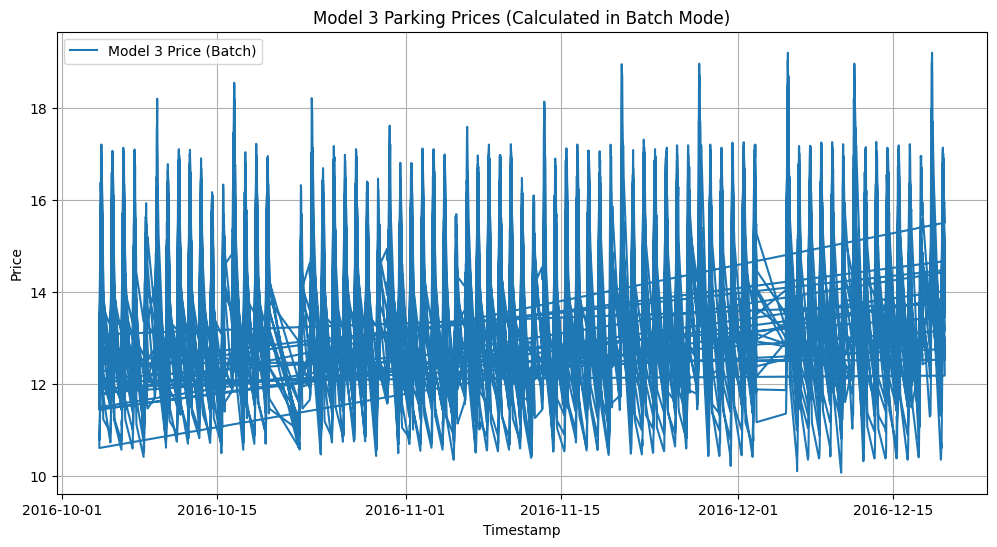

In [10]:
# MODEL 3
import pandas as pd
import numpy as np
print("--- Running FINAL LAST-RESORT ML Prediction (Batch Mode) ---")
print("This completely bypasses Pathway's streaming UDFs due to environment issues.")
print("It calculates price_model3 on the full dataset using Pandas/Scikit-learn.")


# Calculating 'current_occupancy_rate' directly on your original Pandas DataFrame 'df'.
df['current_occupancy_rate'] = df.apply(
    lambda row: row['Occupancy'] / row['Capacity'] if row['Capacity'] != 0 else 0.0,
    axis=1
)

# Defining the features that trained 'model3' (LinearRegression) expects.
features_list = [
    'current_occupancy_rate',
    'QueueLength',
    'TrafficConditionNearby',
    'IsSpecialDay',
    'hour',
    'day_of_week'
]
X_predict = df[features_list].astype(float)

# Performing the prediction using trained scikit-learn model (model3).
# This is a one-time, batch prediction on all available data in 'df'.
predictions = model3.predict(X_predict)
df['price_model3'] = predictions

print("\nML Predictions for 'price_model3' have been calculated successfully in batch mode.")
print("This column is now added to your original Pandas DataFrame 'df'.")
print("\nSample of calculated 'price_model3' values:")
print(df[['ID', 'Timestamp', 'price_model3']].head())

# To visualize this data
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['t_pandas'], df['price_model3'], label='Model 3 Price (Batch)')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Model 3 Parking Prices (Calculated in Batch Mode)')
plt.grid(True)
plt.legend()
plt.show()

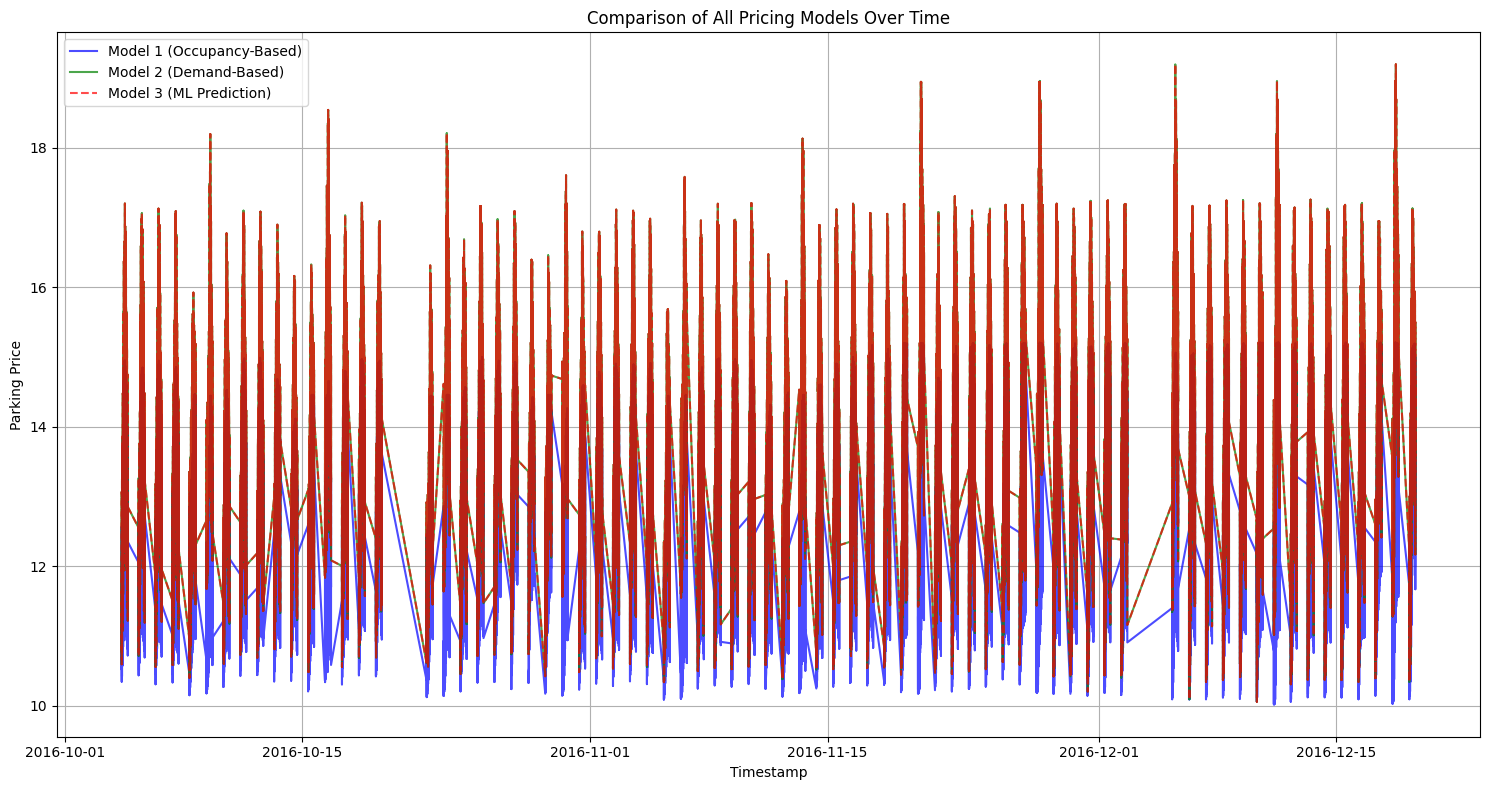

Comparison plot of all three pricing models displayed.


In [11]:
import matplotlib.pyplot as plt

# This cell compares the pricing predictions from all three models.

df['current_occupancy_rate'] = df.apply(
    lambda row: row['Occupancy'] / row['Capacity'] if row['Capacity'] != 0 else 0.0,
    axis=1
)

df['price_model1'] = BASE_PRICE + ALPHA * df['current_occupancy_rate']

df['demand_score'] = (df['QueueLength'] * Q_WEIGHT) + \
                     (df['TrafficConditionNearby'] * T_WEIGHT) + \
                     (df['IsSpecialDay'] * S_WEIGHT)

df['price_model2'] = (BASE_PRICE + ALPHA * df['current_occupancy_rate']) + \
                     (df['demand_score'] * BETA_DEMAND)

df_sorted = df.sort_values(by='t_pandas')

plt.figure(figsize=(15, 8))

plt.plot(df_sorted['t_pandas'], df_sorted['price_model1'], label='Model 1 (Occupancy-Based)', color='blue', alpha=0.7)

plt.plot(df_sorted['t_pandas'], df_sorted['price_model2'], label='Model 2 (Demand-Based)', color='green', alpha=0.7)

plt.plot(df_sorted['t_pandas'], df_sorted['price_model3'], label='Model 3 (ML Prediction)', color='red', alpha=0.7, linestyle='--')

plt.xlabel('Timestamp')
plt.ylabel('Parking Price')
plt.title('Comparison of All Pricing Models Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Comparison plot of all three pricing models displayed.")

In [12]:
import panel as pn
import bokeh.plotting
import pandas as pd

# This cell creates a dashboard to compare the three parking price models.

pn.extension()

def create_price_plot(df_data, price_col, title, line_color, line_style='solid'):
    df_plot = df_data.sort_values(by='t_pandas')
    source = bokeh.models.ColumnDataSource(df_plot)
    fig = bokeh.plotting.figure(
        height=300, width=600,
        title=title, x_axis_type="datetime",
        x_axis_label="Timestamp", y_axis_label="Parking Price",
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )
    fig.line(
        x='t_pandas', y=price_col, source=source,
        line_width=2, color=line_color, line_dash=line_style
    )
    fig.scatter(
        x='t_pandas', y=price_col, source=source,
        size=4, color=line_color, alpha=0.5
    )
    return fig

plot_model1 = create_price_plot(df, 'price_model1', 'Model 1: Occupancy-Based Price', 'blue')
plot_model2 = create_price_plot(df, 'price_model2', 'Model 2: Demand-Based Price', 'green')
plot_model3 = create_price_plot(df, 'price_model3', 'Model 3: ML Predicted Price', 'red', 'dashed')

dashboard = pn.Column(
    pn.pane.Markdown("# Parking Price Models Dashboard"),
    pn.Row(plot_model1, plot_model2),
    pn.Row(plot_model3)
)

try:
    dashboard
    print("Attempted to display dashboard directly in Colab output cell.")
except Exception as e:
    print(f"Could not display dashboard directly in Colab: {e}")

# Saving the dashboard as an HTML file
output_html_file = "parking_price_dashboard.html"
try:
    dashboard.save(output_html_file)
    print(f"Dashboard successfully saved as HTML file: {output_html_file}")
    print("To view it: Go to the 'Files' icon on the left sidebar in Colab, find 'parking_price_dashboard.html', right-click, and select 'Download'. Then open the downloaded file in your web browser.")
except Exception as e:
    print(f"Could not save dashboard as HTML: {e}")

Attempted to display dashboard directly in Colab output cell.
Dashboard successfully saved as HTML file: parking_price_dashboard.html
To view it: Go to the 'Files' icon on the left sidebar in Colab, find 'parking_price_dashboard.html', right-click, and select 'Download'. Then open the downloaded file in your web browser.
